In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

Using TensorFlow backend.


## Data Collection

#### short term interest rate

In [2]:
stir = pd.read_csv('var/short_term_int_rate_q.csv')

In [3]:
stir = stir[['TIME', 'Value']].copy()

In [4]:
stir['date'] = pd.to_datetime(stir['TIME'])

#### inflation rate

In [5]:
ir_ = pd.read_csv('var/inflation_rate_m.csv')
ir = []
for i in range(len(ir_.iloc[:, 1:13])):
    ir = ir + ir_.iloc[i, 1:13].tolist()
ir = ir[:-9]
ir = [float(ir[i]) for i in range(len(ir))]
ir_dt = []
for i in range(len(ir)):
    y = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).year
    m = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).month
    ir_dt.append(str(y)+'-'+str(m))
ir = pd.DataFrame([ir_dt, ir], index=['TIME', 'Value']).T

In [6]:
ir = ir.iloc[:-3, :].copy()

In [7]:
ir['date'] = ir['TIME'].map(lambda x: pd.Period(x,'Q'))

In [8]:
ir = ir[['date', 'Value']].copy()

In [9]:
ir['Value'] = ir['Value'].astype(float)

In [10]:
ir['date'] = ir['date'].astype(str)

In [11]:
quarters = pd.unique(ir['date']).tolist()

In [12]:
g = ir.groupby('date')['Value']

In [13]:
ir_q = []
for q in quarters:
    l_g = g.get_group(q).tolist()
    l_g_m = [i*0.01 for i in l_g]
    current = 1
    for i in l_g_m:
        current = current + current*i
    ir_q.append((current-1)*100)

In [14]:
ir = pd.DataFrame([ir_q, pd.to_datetime(quarters).tolist()], ['Value', 'date']).T

#### GDP

In [15]:
gdp = pd.read_csv('var/gdp_m_q.csv')

In [16]:
gdp = gdp[
    gdp['Subject']=='National Accounts > GDP by Expenditure > Constant Prices > Gross Domestic Product - Total'
].copy()

In [17]:
gdp = gdp[gdp['Measure']=='Level, rate or national currency, s.a.'].copy()

In [18]:
gdp = gdp[gdp['FREQUENCY']=='Q'].copy()

In [19]:
gdp = gdp[['Subject', 'Measure', 'FREQUENCY', 'TIME', 'Time', 'Unit Code', 'Value']].copy()

In [20]:
gdp = gdp.reset_index(drop=True)

In [21]:
gdp = gdp[['TIME', 'Value']].copy()

In [22]:
gdp['date'] = pd.to_datetime(gdp['TIME']).tolist()

#### Make full DF

In [23]:
gdp.index = gdp['date']
gdp = gdp[['Value']].copy()

In [24]:
stir.index = stir['date']
stir = stir[['Value']].copy()

In [25]:
ir.index = ir['date']
ir = ir[['Value']].copy()

In [26]:
df_var_t = pd.concat([gdp, stir, ir], axis=1).dropna()
df_var_t.columns = ['gdp', 'stir', 'infr']

## Stationarity part

Results of Dickey-Fuller Test:
Test Statistic                   1.137740
p-value                          0.995526
#Lags Used                       2.000000
Number of Observations Used    207.000000
Critical Value (5%)             -2.875606
Critical Value (10%)            -2.574267
Critical Value (1%)             -3.462342
dtype: float64


Results of KPSS Test:
Test Statistic            1.407291
p-value                   0.010000
#Lags Used               15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


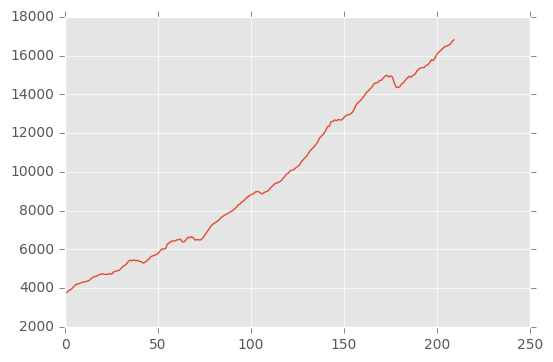

In [27]:
test_stationarity(df_var_t['gdp'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.754592
p-value                          0.403227
#Lags Used                       7.000000
Number of Observations Used    202.000000
Critical Value (5%)             -2.875957
Critical Value (10%)            -2.574455
Critical Value (1%)             -3.463144
dtype: float64


Results of KPSS Test:
Test Statistic            0.805212
p-value                   0.010000
#Lags Used               15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


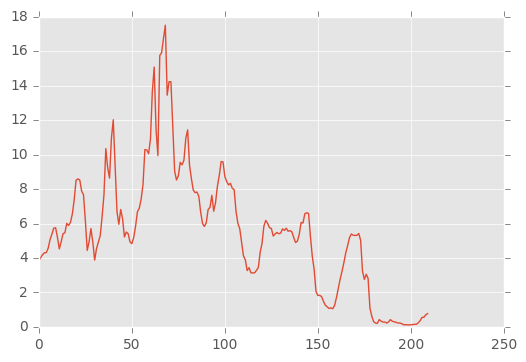

In [28]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.628578
p-value                          0.468235
#Lags Used                      12.000000
Number of Observations Used    197.000000
Critical Value (5%)             -2.876326
Critical Value (10%)            -2.574652
Critical Value (1%)             -3.463987
dtype: float64


Results of KPSS Test:
Test Statistic            0.627924
p-value                   0.020098
#Lags Used               15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


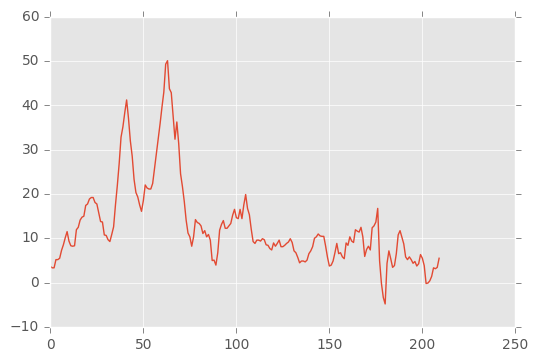

In [29]:
test_stationarity(df_var_t['infr'])

Разности

Results of Dickey-Fuller Test:
Test Statistic                -6.729151e+00
p-value                        3.330094e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.070000e+02
Critical Value (5%)           -2.875606e+00
Critical Value (10%)          -2.574267e+00
Critical Value (1%)           -3.462342e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.305495
p-value                   0.100000
#Lags Used               15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


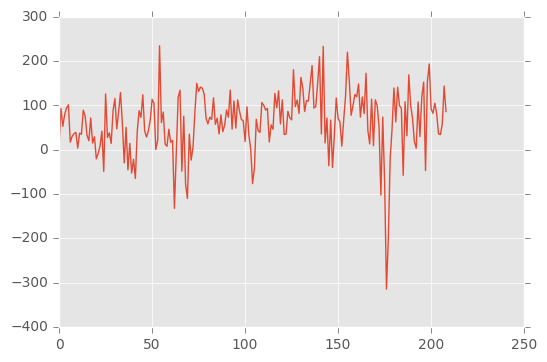

In [30]:
test_stationarity(diff_series(df_var_t['gdp']))

Results of Dickey-Fuller Test:
Test Statistic                -5.919963e+00
p-value                        2.520096e-07
#Lags Used                     6.000000e+00
Number of Observations Used    2.020000e+02
Critical Value (5%)           -2.875957e+00
Critical Value (10%)          -2.574455e+00
Critical Value (1%)           -3.463144e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.120741
p-value                   0.100000
#Lags Used               15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


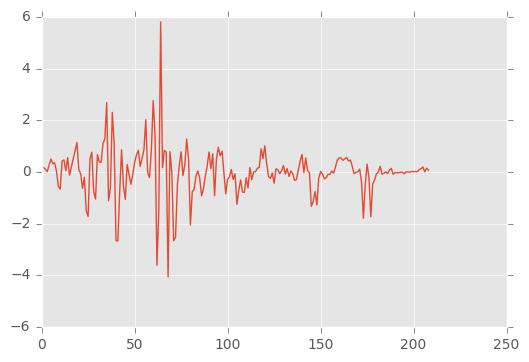

In [31]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                  -5.493664
p-value                          0.000002
#Lags Used                      15.000000
Number of Observations Used    193.000000
Critical Value (5%)             -2.876635
Critical Value (10%)            -2.574816
Critical Value (1%)             -3.464694
dtype: float64


Results of KPSS Test:
Test Statistic            0.110707
p-value                   0.100000
#Lags Used               15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


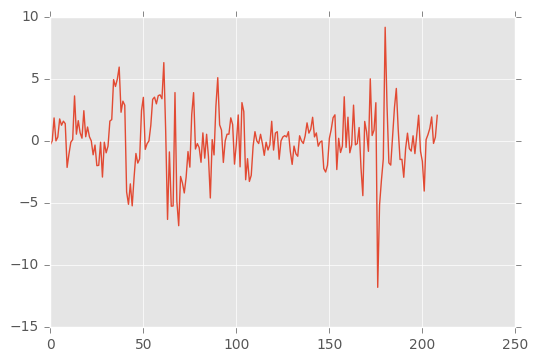

In [32]:
test_stationarity(diff_series(df_var_t['infr']))

In [33]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

#### 6 steps

In [34]:
STEPS = 8
LAG = 4

In [35]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [36]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [37]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='q')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['gdp'], test['gdp']))

{'mae': 0.10543894452460223, 'mse': 0.015028682796052418, 'rmse': 0.12259152823932173}
{'mae': 1.285443209474421, 'mse': 2.7079346037952794, 'rmse': 1.6455803243218725}
{'mae': 30.877947117875859, 'mse': 1417.7378762052122, 'rmse': 37.652860133132144}


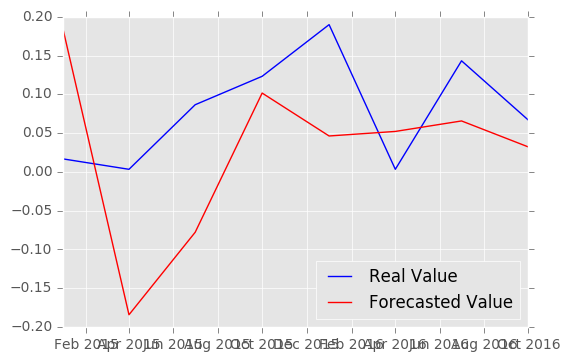

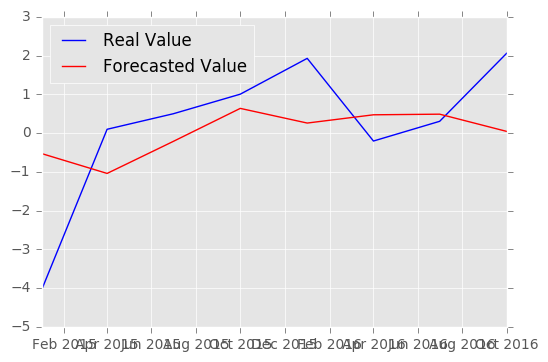

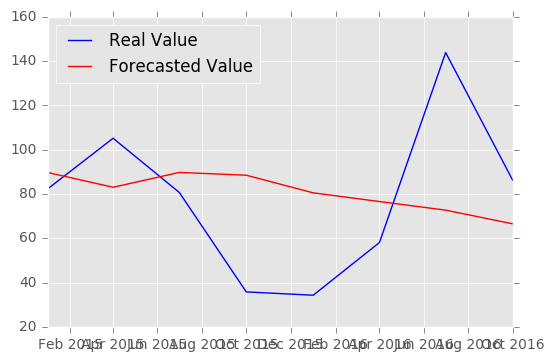

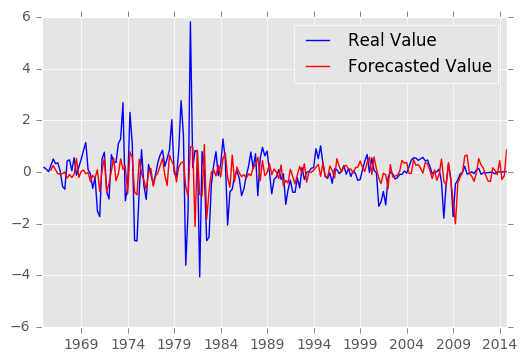

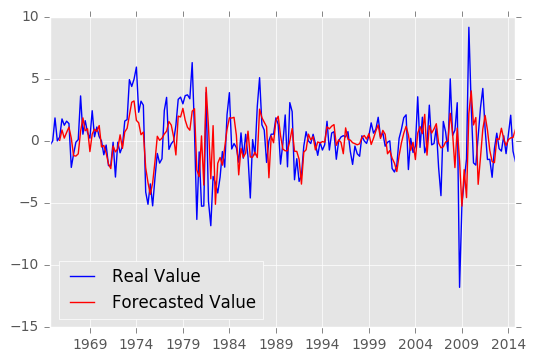

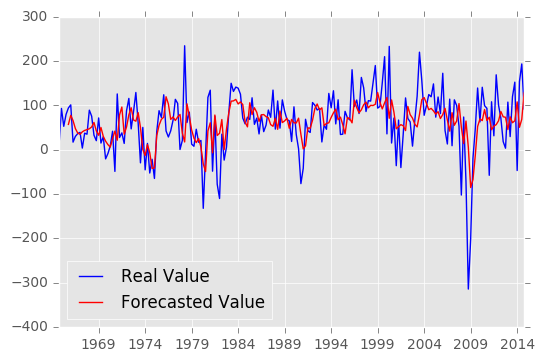

In [38]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['gdp'], test['gdp'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['gdp'], train['gdp'])

{'mae': 0.25463120208029938, 'mse': 0.080145648750673149, 'rmse': 0.28310006843989483}
{'mae': 1.4445819365422845, 'mse': 3.1634910293011065, 'rmse': 1.7786205411219973}
{'mae': 42.678798130785708, 'mse': 3225.6291546645962, 'rmse': 56.794622585809975}


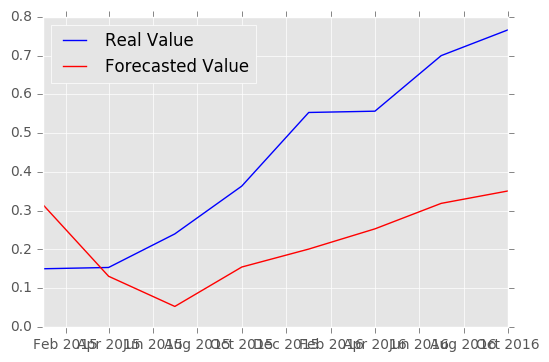

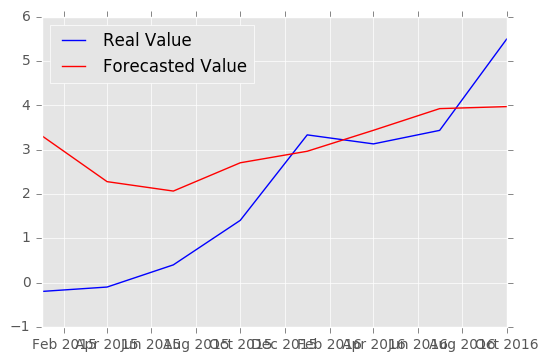

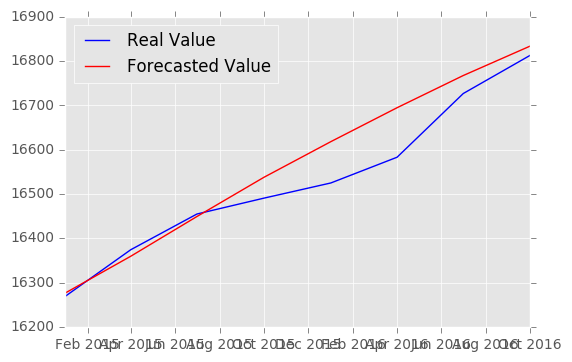

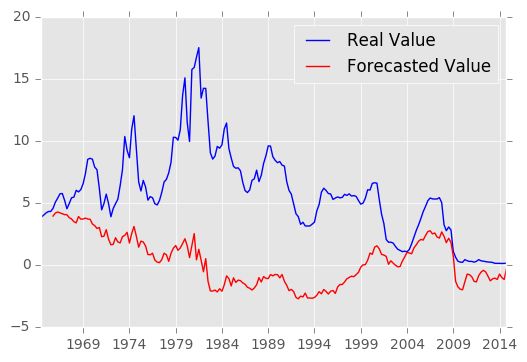

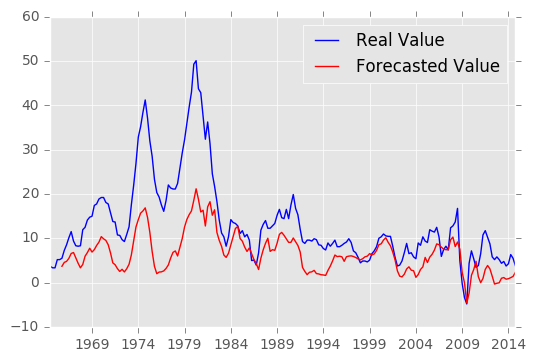

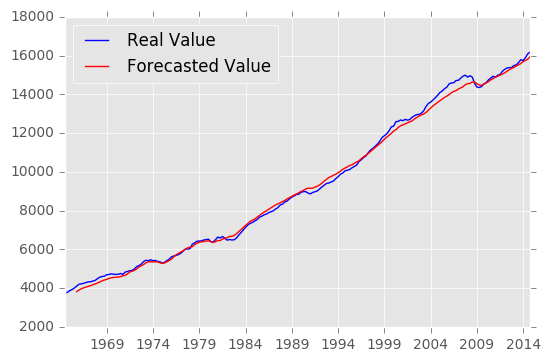

In [39]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['gdp'], test_real['gdp']))
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['gdp'], test_real['gdp'])
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['gdp'], train_real['gdp'])

## ANN

In [40]:
df_nn = nn_transform(train, n=LAG)

In [41]:
df_nn_s, m, s = scaler(df_nn)

In [42]:
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [43]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100, period='q'):
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

Первый запуск

In [44]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [45]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.1658
Epoch 2/600
0s - loss: 0.9925
Epoch 3/600
0s - loss: 0.9729
Epoch 4/600
0s - loss: 0.9626
Epoch 5/600
0s - loss: 0.9495
Epoch 6/600
0s - loss: 0.9378
Epoch 7/600
0s - loss: 0.9293
Epoch 8/600
0s - loss: 0.9181
Epoch 9/600
0s - loss: 0.9098
Epoch 10/600
0s - loss: 0.8989
Epoch 11/600
0s - loss: 0.8898
Epoch 12/600
0s - loss: 0.8800
Epoch 13/600
0s - loss: 0.8687
Epoch 14/600
0s - loss: 0.8598
Epoch 15/600
0s - loss: 0.8497
Epoch 16/600
0s - loss: 0.8395
Epoch 17/600
0s - loss: 0.8296
Epoch 18/600
0s - loss: 0.8239
Epoch 19/600
0s - loss: 0.8128
Epoch 20/600
0s - loss: 0.8079
Epoch 21/600
0s - loss: 0.8002
Epoch 22/600
0s - loss: 0.7952
Epoch 23/600
0s - loss: 0.7893
Epoch 24/600
0s - loss: 0.7842
Epoch 25/600
0s - loss: 0.7783
Epoch 26/600
0s - loss: 0.7755
Epoch 27/600
0s - loss: 0.7709
Epoch 28/600
0s - loss: 0.7662
Epoch 29/600
0s - loss: 0.7610
Epoch 30/600
0s - loss: 0.7585
Epoch 31/600
0s - loss: 0.7550
Epoch 32/600
0s - loss: 0.7516
Epoch 33/600
0s -

In [46]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

{'mae': 0.23046761484326056, 'mse': 0.068784290394149794, 'rmse': 0.26226759310702075}
{'mae': 1.5672411049546549, 'mse': 5.5613058072079511, 'rmse': 2.3582421010591661}
{'mae': 24.818039041714798, 'mse': 978.11365379205211, 'rmse': 31.274808613196214}


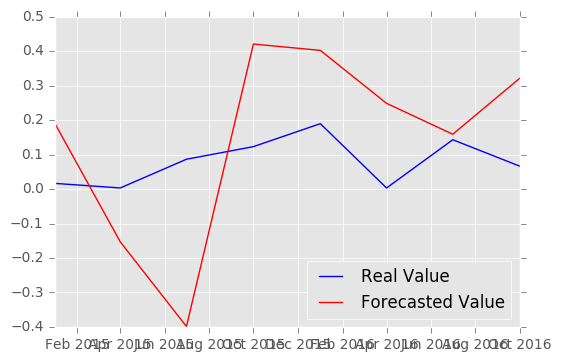

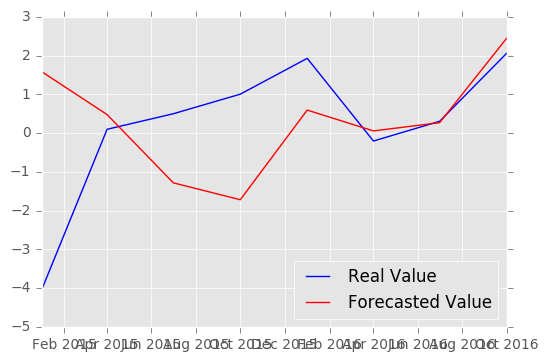

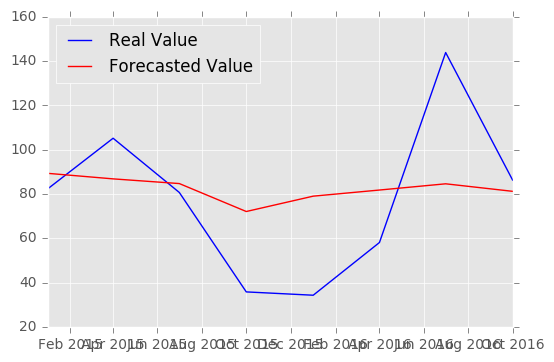

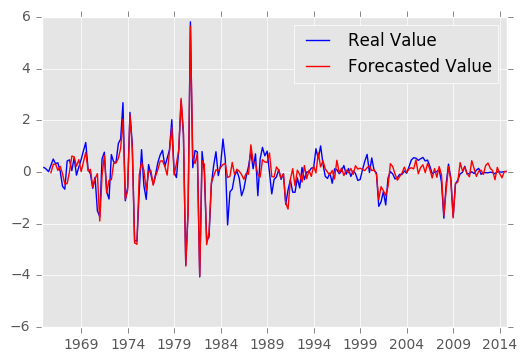

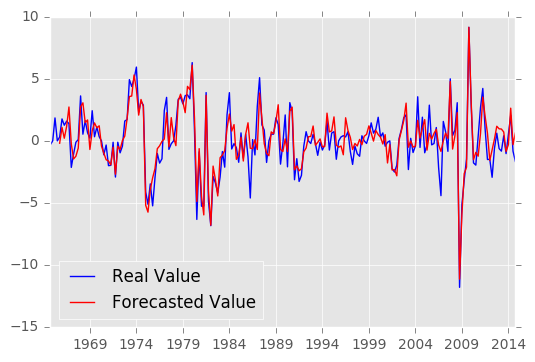

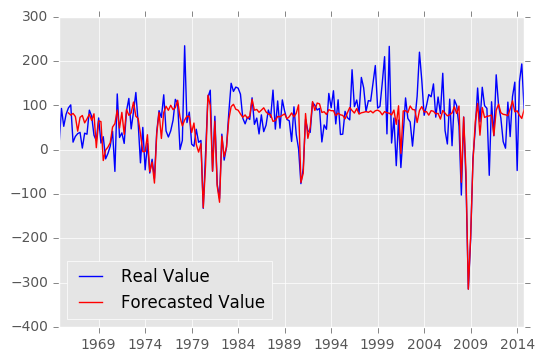

In [47]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 0.25343122947127228, 'mse': 0.096265820486368919, 'rmse': 0.31026733712456572}
{'mae': 2.3962836011578723, 'mse': 11.132630774085509, 'rmse': 3.3365597213425553}
{'mae': 37.152419693938327, 'mse': 2321.5657852250301, 'rmse': 48.182629496790959}


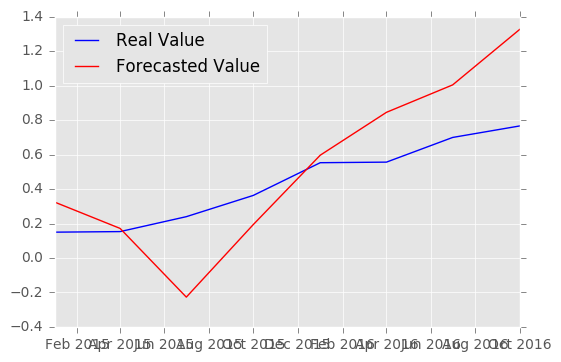

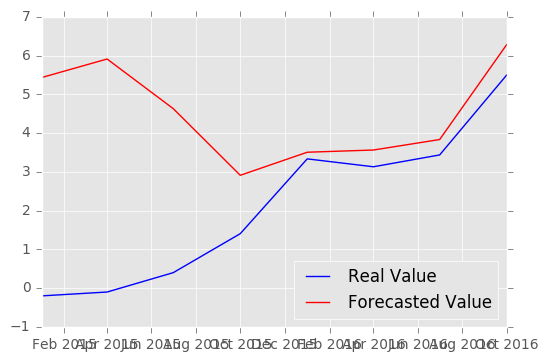

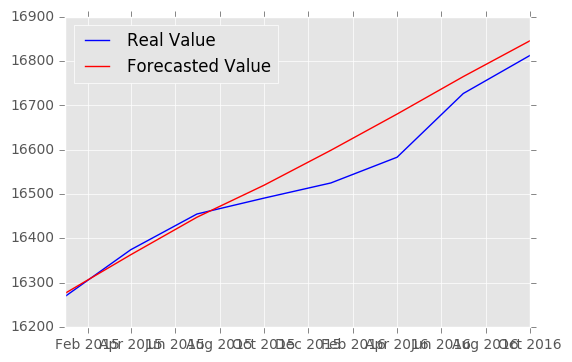

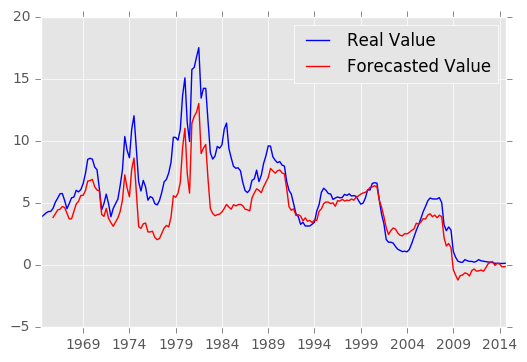

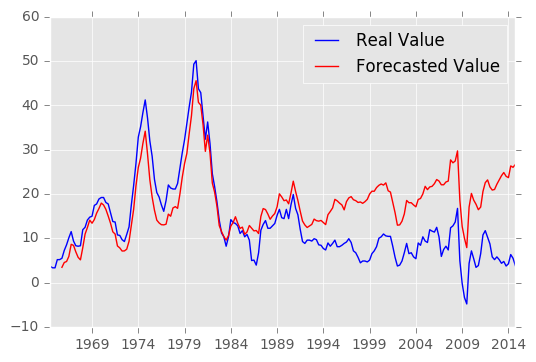

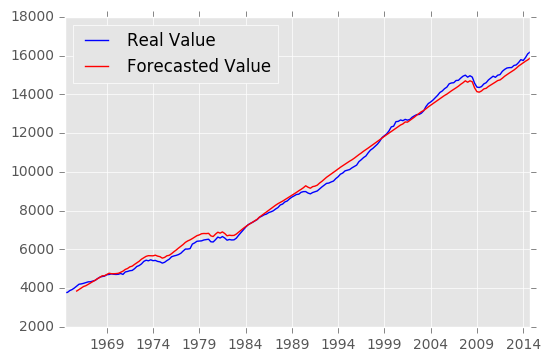

In [48]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

Второй запуск

In [49]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.1187
Epoch 2/600
0s - loss: 0.9901
Epoch 3/600
0s - loss: 0.9719
Epoch 4/600
0s - loss: 0.9617
Epoch 5/600
0s - loss: 0.9528
Epoch 6/600
0s - loss: 0.9398
Epoch 7/600
0s - loss: 0.9323
Epoch 8/600
0s - loss: 0.9208
Epoch 9/600
0s - loss: 0.9104
Epoch 10/600
0s - loss: 0.8985
Epoch 11/600
0s - loss: 0.8890
Epoch 12/600
0s - loss: 0.8799
Epoch 13/600
0s - loss: 0.8709
Epoch 14/600
0s - loss: 0.8596
Epoch 15/600
0s - loss: 0.8543
Epoch 16/600
0s - loss: 0.8447
Epoch 17/600
0s - loss: 0.8353
Epoch 18/600
0s - loss: 0.8284
Epoch 19/600
0s - loss: 0.8226
Epoch 20/600
0s - loss: 0.8136
Epoch 21/600
0s - loss: 0.8062
Epoch 22/600
0s - loss: 0.8002
Epoch 23/600
0s - loss: 0.7956
Epoch 24/600
0s - loss: 0.7904
Epoch 25/600
0s - loss: 0.7853
Epoch 26/600
0s - loss: 0.7778
Epoch 27/600
0s - loss: 0.7721
Epoch 28/600
0s - loss: 0.7678
Epoch 29/600
0s - loss: 0.7635
Epoch 30/600
0s - loss: 0.7580
Epoch 31/600
0s - loss: 0.7565
Epoch 32/600
0s - loss: 0.7516
Epoch 33/600
0s -

{'mae': 1.6155793941067456, 'mse': 4.5097560283791749, 'rmse': 2.1236186165079585}
{'mae': 3.7874663852052395, 'mse': 18.747898032371509, 'rmse': 4.3298842978042158}
{'mae': 46.204425170402843, 'mse': 4201.2813022246673, 'rmse': 64.817291691528325}


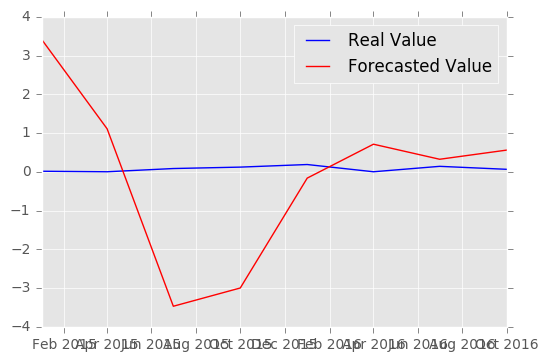

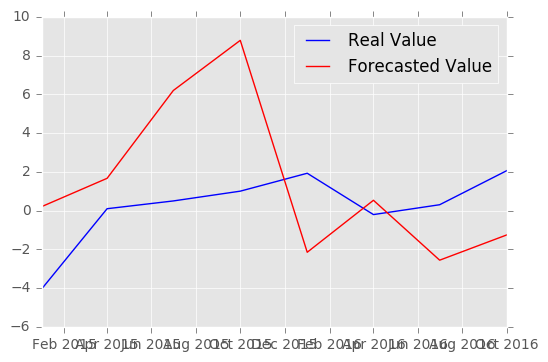

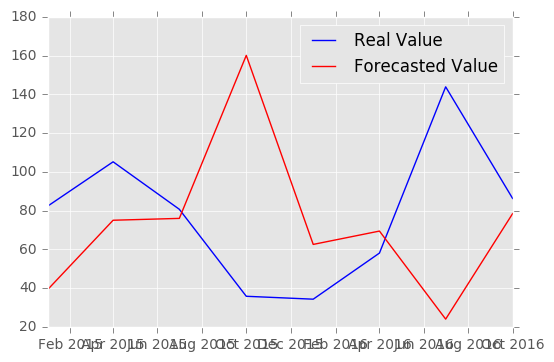

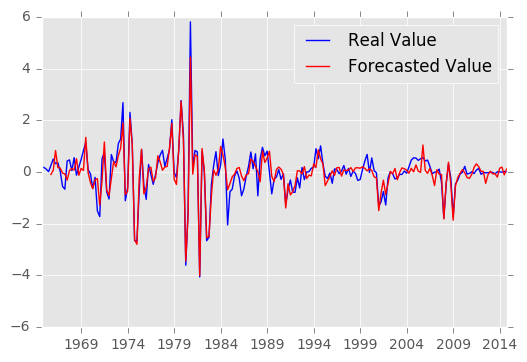

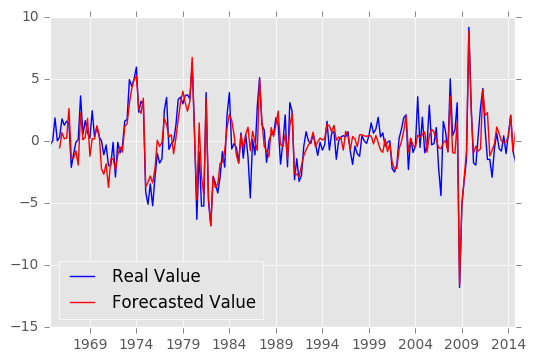

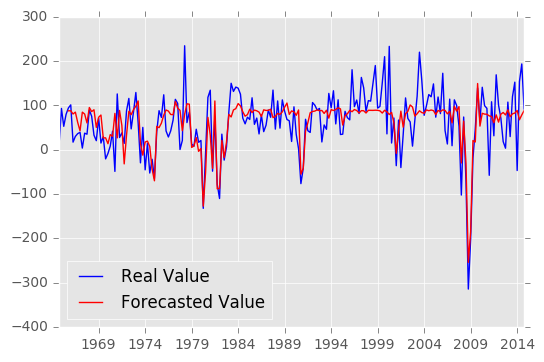

In [50]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 2.2610924263427945, 'mse': 6.3701457268629404, 'rmse': 2.5239147622023492}
{'mae': 11.873170576427086, 'mse': 163.96221821730305, 'rmse': 12.804773259113301}
{'mae': 59.616539636574316, 'mse': 3913.6633475276585, 'rmse': 62.559278668536919}


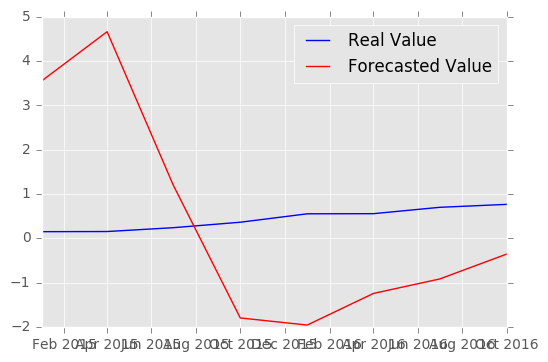

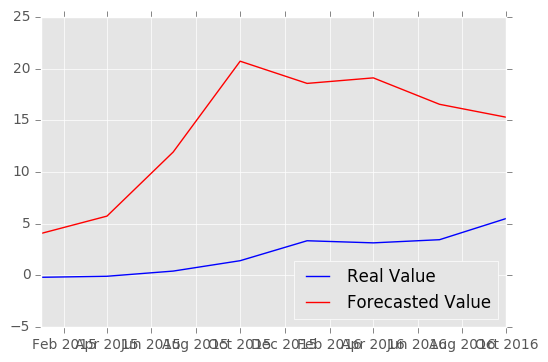

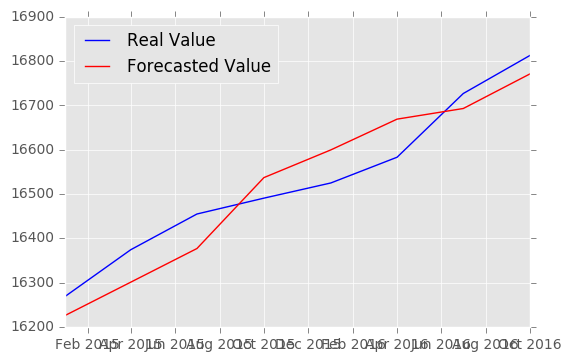

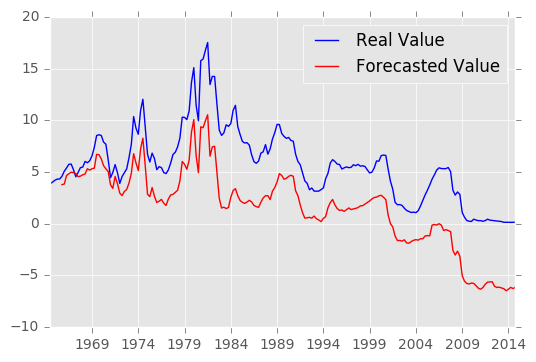

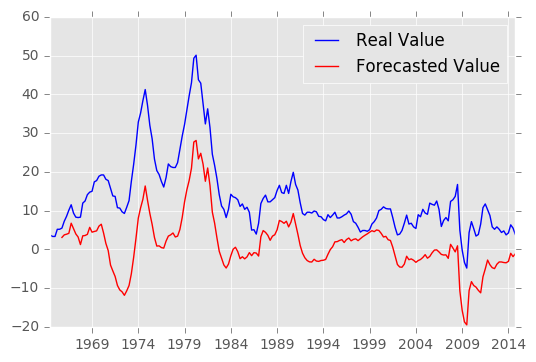

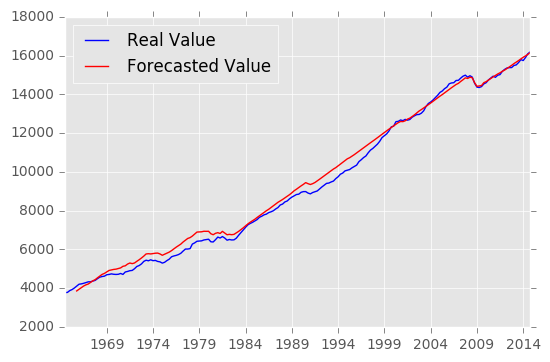

In [51]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

С DropOut

In [52]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.2321
Epoch 2/600
0s - loss: 1.0471
Epoch 3/600
0s - loss: 1.0192
Epoch 4/600
0s - loss: 1.0245
Epoch 5/600
0s - loss: 1.0260
Epoch 6/600
0s - loss: 1.0028
Epoch 7/600
0s - loss: 1.0161
Epoch 8/600
0s - loss: 1.0089
Epoch 9/600
0s - loss: 1.0085
Epoch 10/600
0s - loss: 0.9993
Epoch 11/600
0s - loss: 0.9815
Epoch 12/600
0s - loss: 1.0019
Epoch 13/600
0s - loss: 0.9831
Epoch 14/600
0s - loss: 0.9945
Epoch 15/600
0s - loss: 0.9906
Epoch 16/600
0s - loss: 0.9789
Epoch 17/600
0s - loss: 0.9838
Epoch 18/600
0s - loss: 0.9802
Epoch 19/600
0s - loss: 0.9642
Epoch 20/600
0s - loss: 0.9756
Epoch 21/600
0s - loss: 0.9617
Epoch 22/600
0s - loss: 0.9389
Epoch 23/600
0s - loss: 0.9448
Epoch 24/600
0s - loss: 0.9378
Epoch 25/600
0s - loss: 0.9108
Epoch 26/600
0s - loss: 0.9154
Epoch 27/600
0s - loss: 0.9210
Epoch 28/600
0s - loss: 0.8992
Epoch 29/600
0s - loss: 0.9154
Epoch 30/600
0s - loss: 0.9245
Epoch 31/600
0s - loss: 0.9115
Epoch 32/600
0s - loss: 0.8795
Epoch 33/600
0s -

{'mae': 0.075340092725332306, 'mse': 0.0063273621053707707, 'rmse': 0.079544717645930269}
{'mae': 1.5130647263648527, 'mse': 3.5224940675305438, 'rmse': 1.876830857464397}
{'mae': 26.362795776076808, 'mse': 1179.4084535791978, 'rmse': 34.342516704213715}


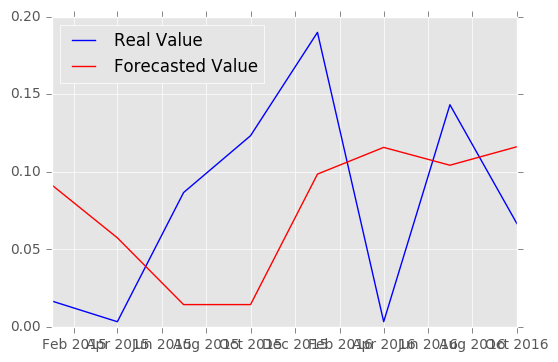

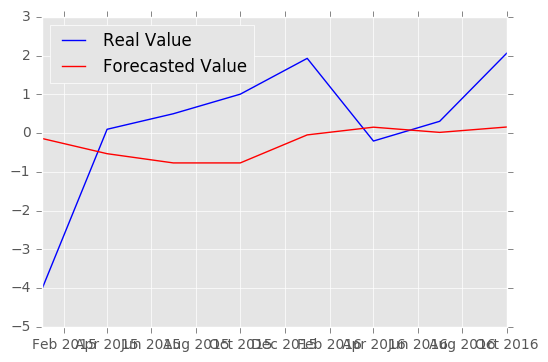

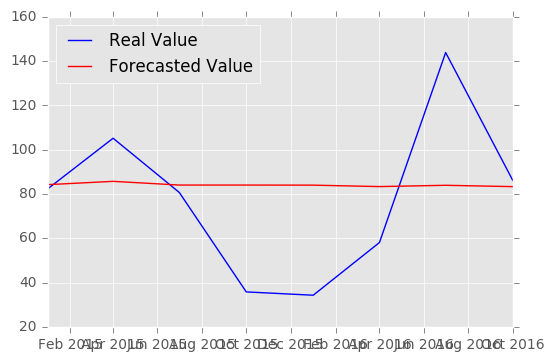

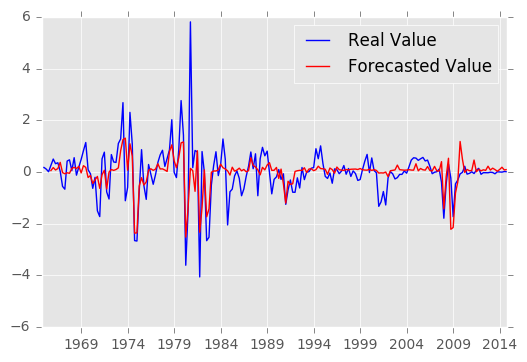

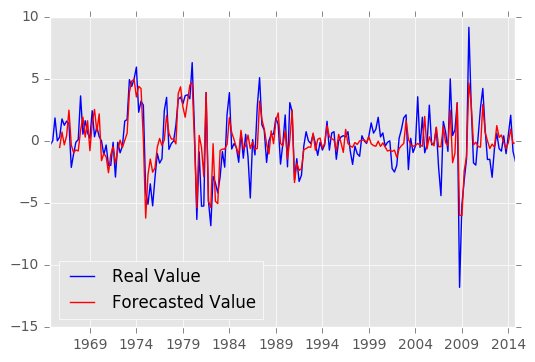

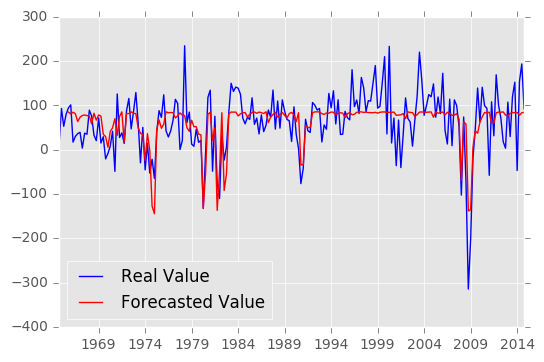

In [53]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 0.07232134777794183, 'mse': 0.006895281434347875, 'rmse': 0.083037831344200425}
{'mae': 2.224056274699493, 'mse': 6.3238415333395519, 'rmse': 2.514724941885206}
{'mae': 44.476824034848732, 'mse': 3140.8430948393766, 'rmse': 56.043225235878211}


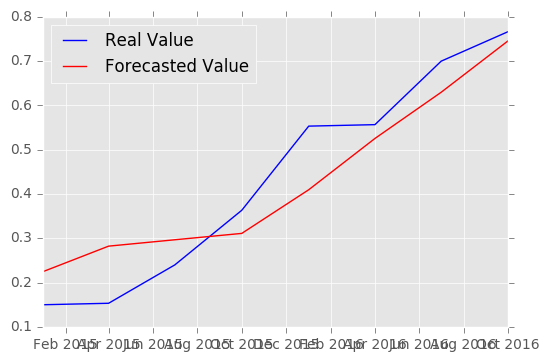

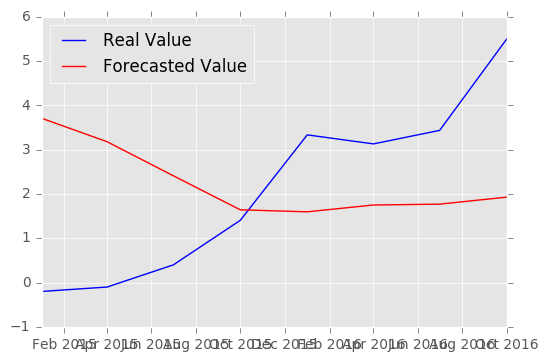

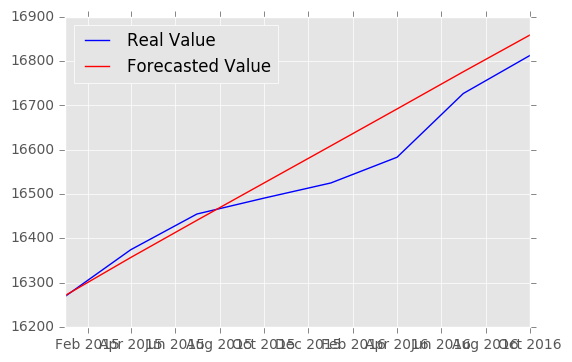

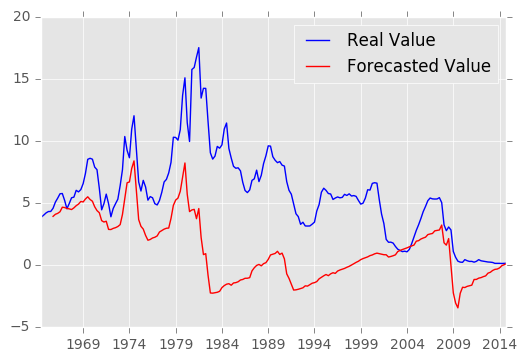

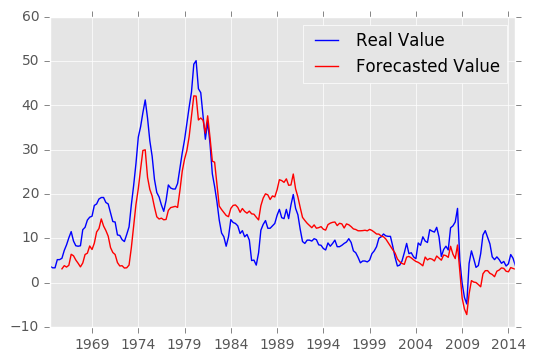

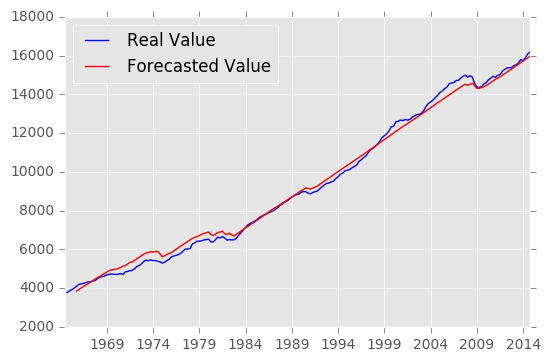

In [54]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

На оригинальных данных, а не разницах

In [55]:
df_nn = nn_transform(train_real, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [56]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 0.9751
Epoch 2/600
0s - loss: 0.7373
Epoch 3/600
0s - loss: 0.5435
Epoch 4/600
0s - loss: 0.4232
Epoch 5/600
0s - loss: 0.3663
Epoch 6/600
0s - loss: 0.3340
Epoch 7/600
0s - loss: 0.3065
Epoch 8/600
0s - loss: 0.2797
Epoch 9/600
0s - loss: 0.2529
Epoch 10/600
0s - loss: 0.2259
Epoch 11/600
0s - loss: 0.2035
Epoch 12/600
0s - loss: 0.1813
Epoch 13/600
0s - loss: 0.1625
Epoch 14/600
0s - loss: 0.1459
Epoch 15/600
0s - loss: 0.1314
Epoch 16/600
0s - loss: 0.1203
Epoch 17/600
0s - loss: 0.1088
Epoch 18/600
0s - loss: 0.1002
Epoch 19/600
0s - loss: 0.0931
Epoch 20/600
0s - loss: 0.0871
Epoch 21/600
0s - loss: 0.0821
Epoch 22/600
0s - loss: 0.0770
Epoch 23/600
0s - loss: 0.0737
Epoch 24/600
0s - loss: 0.0713
Epoch 25/600
0s - loss: 0.0695
Epoch 26/600
0s - loss: 0.0676
Epoch 27/600
0s - loss: 0.0655
Epoch 28/600
0s - loss: 0.0639
Epoch 29/600
0s - loss: 0.0620
Epoch 30/600
0s - loss: 0.0610
Epoch 31/600
0s - loss: 0.0608
Epoch 32/600
0s - loss: 0.0592
Epoch 33/600
0s -

{'mae': 1.3928971733924393, 'mse': 4.1040472758540112, 'rmse': 2.025844830152105}
{'mae': 3.0309285053143213, 'mse': 24.299316168304042, 'rmse': 4.9294336559389906}
{'mae': 3485.8343308387589, 'mse': 13276460.250007091, 'rmse': 3643.6877267415621}


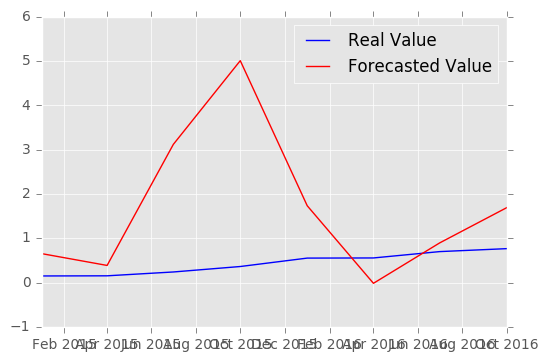

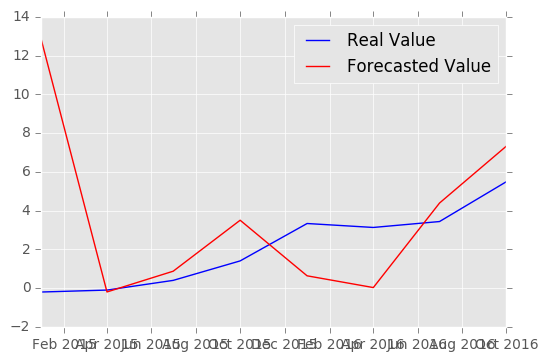

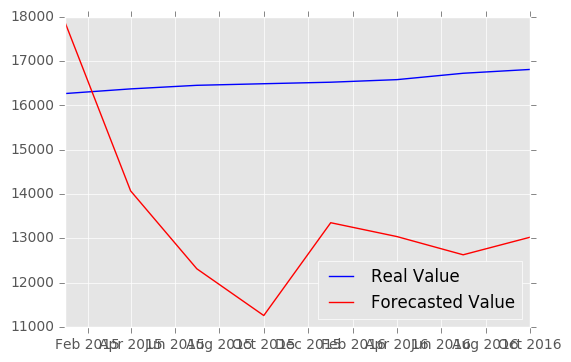

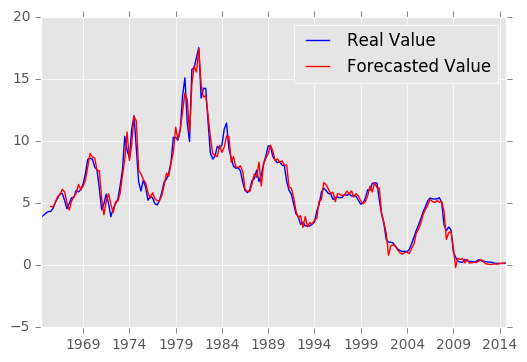

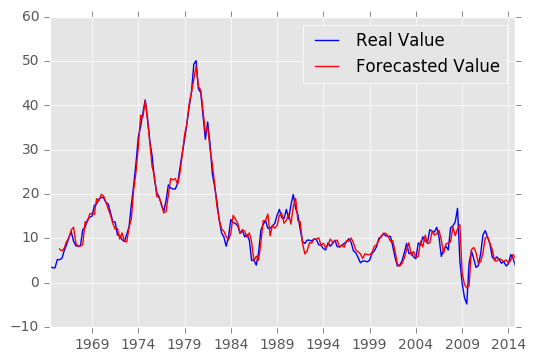

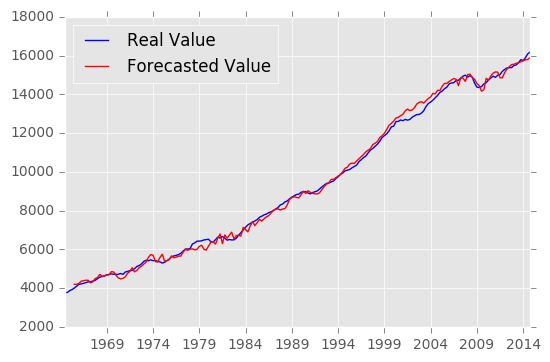

In [57]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

Второй запуск (не на разницах)

In [58]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.2958
Epoch 2/600
0s - loss: 0.9200
Epoch 3/600
0s - loss: 0.7936
Epoch 4/600
0s - loss: 0.6763
Epoch 5/600
0s - loss: 0.5527
Epoch 6/600
0s - loss: 0.4472
Epoch 7/600
0s - loss: 0.3718
Epoch 8/600
0s - loss: 0.3238
Epoch 9/600
0s - loss: 0.2868
Epoch 10/600
0s - loss: 0.2595
Epoch 11/600
0s - loss: 0.2364
Epoch 12/600
0s - loss: 0.2174
Epoch 13/600
0s - loss: 0.1981
Epoch 14/600
0s - loss: 0.1803
Epoch 15/600
0s - loss: 0.1673
Epoch 16/600
0s - loss: 0.1530
Epoch 17/600
0s - loss: 0.1432
Epoch 18/600
0s - loss: 0.1335
Epoch 19/600
0s - loss: 0.1243
Epoch 20/600
0s - loss: 0.1169
Epoch 21/600
0s - loss: 0.1096
Epoch 22/600
0s - loss: 0.1030
Epoch 23/600
0s - loss: 0.0969
Epoch 24/600
0s - loss: 0.0904
Epoch 25/600
0s - loss: 0.0848
Epoch 26/600
0s - loss: 0.0805
Epoch 27/600
0s - loss: 0.0763
Epoch 28/600
0s - loss: 0.0723
Epoch 29/600
0s - loss: 0.0695
Epoch 30/600
0s - loss: 0.0669
Epoch 31/600
0s - loss: 0.0644
Epoch 32/600
0s - loss: 0.0623
Epoch 33/600
0s -

{'mae': 3.0984720998734532, 'mse': 12.997635972994498, 'rmse': 3.6052234289977783}
{'mae': 5.651119984090009, 'mse': 60.624797818066831, 'rmse': 7.7861927678466083}
{'mae': 951.87323733727703, 'mse': 1230044.9666670293, 'rmse': 1109.0739229947792}


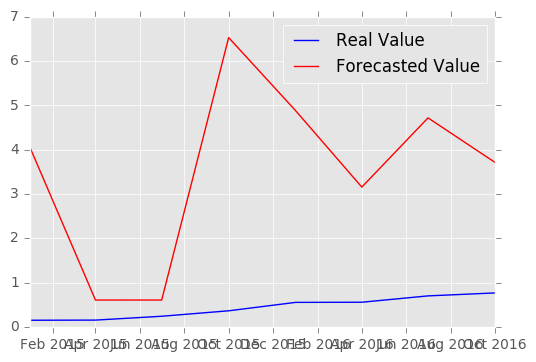

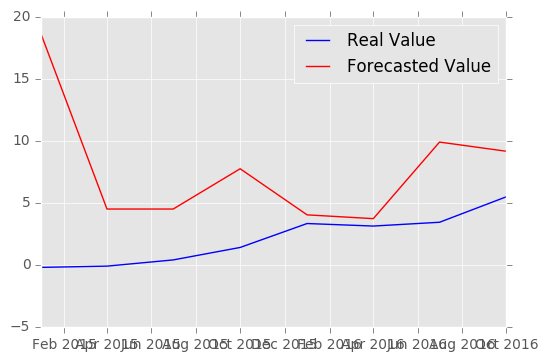

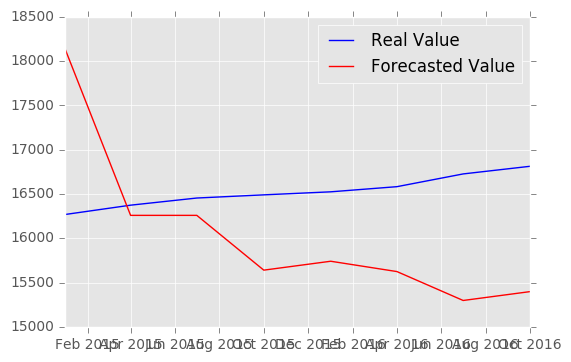

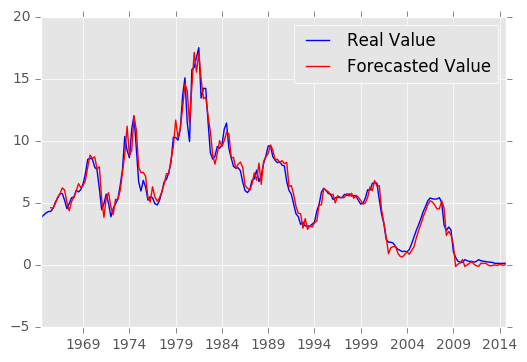

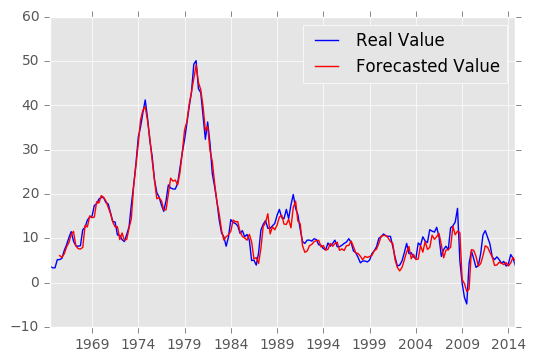

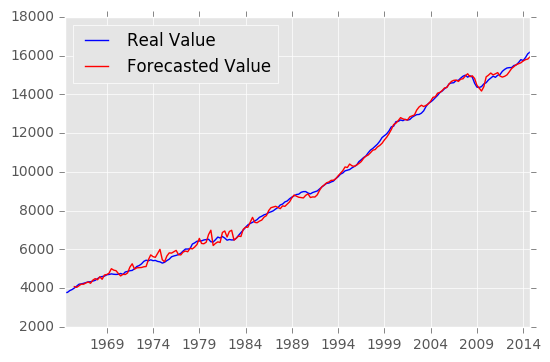

In [59]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

С DropOut

In [60]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 0.9276
Epoch 2/600
0s - loss: 0.7143
Epoch 3/600
0s - loss: 0.5395
Epoch 4/600
0s - loss: 0.4145
Epoch 5/600
0s - loss: 0.3475
Epoch 6/600
0s - loss: 0.3068
Epoch 7/600
0s - loss: 0.2731
Epoch 8/600
0s - loss: 0.2386
Epoch 9/600
0s - loss: 0.2119
Epoch 10/600
0s - loss: 0.1844
Epoch 11/600
0s - loss: 0.1608
Epoch 12/600
0s - loss: 0.1419
Epoch 13/600
0s - loss: 0.1241
Epoch 14/600
0s - loss: 0.1113
Epoch 15/600
0s - loss: 0.0994
Epoch 16/600
0s - loss: 0.0901
Epoch 17/600
0s - loss: 0.0836
Epoch 18/600
0s - loss: 0.0784
Epoch 19/600
0s - loss: 0.0736
Epoch 20/600
0s - loss: 0.0705
Epoch 21/600
0s - loss: 0.0668
Epoch 22/600
0s - loss: 0.0658
Epoch 23/600
0s - loss: 0.0624
Epoch 24/600
0s - loss: 0.0638
Epoch 25/600
0s - loss: 0.0610
Epoch 26/600
0s - loss: 0.0593
Epoch 27/600
0s - loss: 0.0586
Epoch 28/600
0s - loss: 0.0572
Epoch 29/600
0s - loss: 0.0561
Epoch 30/600
0s - loss: 0.0555
Epoch 31/600
0s - loss: 0.0546
Epoch 32/600
0s - loss: 0.0542
Epoch 33/600
0s -

{'mae': 3.3499621854163135, 'mse': 13.358562469467163, 'rmse': 3.6549367257816057}
{'mae': 10.167469906425438, 'mse': 132.51811692819956, 'rmse': 11.51165135539639}
{'mae': 2796.6999318659209, 'mse': 12153043.215035321, 'rmse': 3486.121514668604}


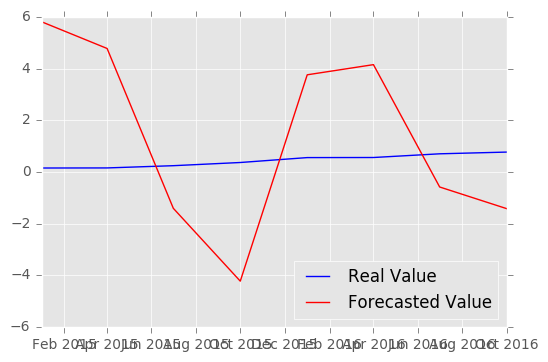

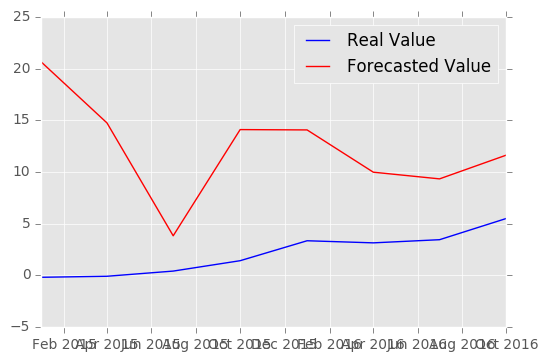

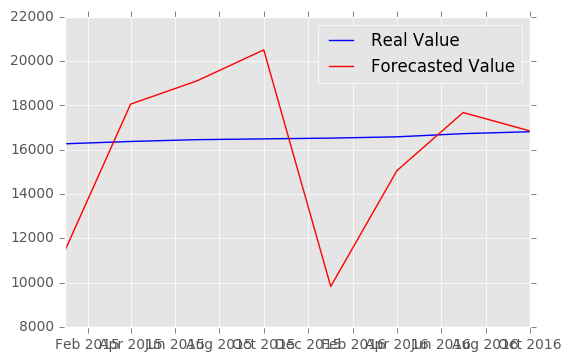

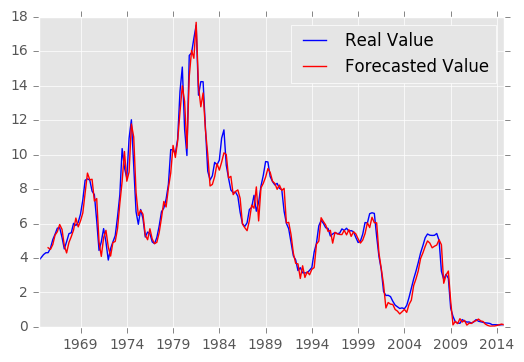

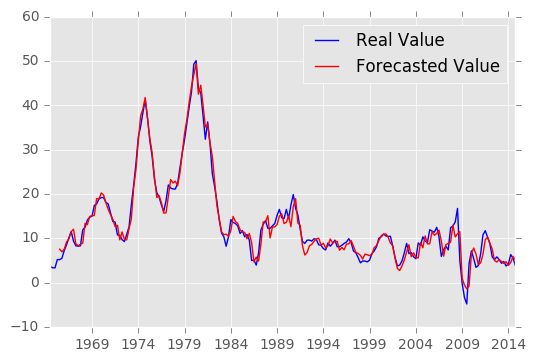

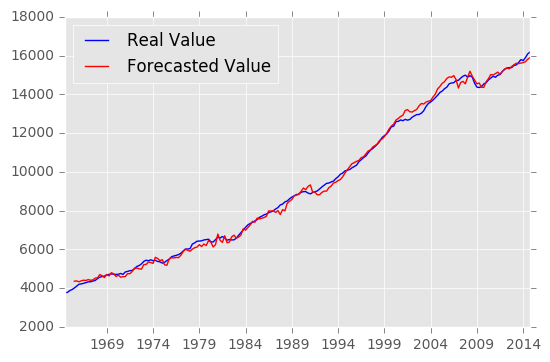

In [61]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

## Hybrid

In [62]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [63]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [64]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.0364
Epoch 2/200
0s - loss: 1.0065
Epoch 3/200
0s - loss: 1.0034
Epoch 4/200
0s - loss: 1.0004
Epoch 5/200
0s - loss: 1.0022
Epoch 6/200
0s - loss: 1.0001
Epoch 7/200
0s - loss: 0.9985
Epoch 8/200
0s - loss: 0.9952
Epoch 9/200
0s - loss: 0.9950
Epoch 10/200
0s - loss: 0.9942
Epoch 11/200
0s - loss: 0.9929
Epoch 12/200
0s - loss: 0.9927
Epoch 13/200
0s - loss: 0.9905
Epoch 14/200
0s - loss: 0.9875
Epoch 15/200
0s - loss: 0.9874
Epoch 16/200
0s - loss: 0.9855
Epoch 17/200
0s - loss: 0.9846
Epoch 18/200
0s - loss: 0.9827
Epoch 19/200
0s - loss: 0.9825
Epoch 20/200
0s - loss: 0.9811
Epoch 21/200
0s - loss: 0.9794
Epoch 22/200
0s - loss: 0.9769
Epoch 23/200
0s - loss: 0.9772
Epoch 24/200
0s - loss: 0.9757
Epoch 25/200
0s - loss: 0.9741
Epoch 26/200
0s - loss: 0.9730
Epoch 27/200
0s - loss: 0.9719
Epoch 28/200
0s - loss: 0.9700
Epoch 29/200
0s - loss: 0.9684
Epoch 30/200
0s - loss: 0.9681
Epoch 31/200
0s - loss: 0.9639
Epoch 32/200
0s - loss: 0.9621
Epoch 33/200
0s -

{'mae': 0.36473612475606243, 'mse': 0.22747660169448033, 'rmse': 0.47694507198888253}
{'mae': 2.9821545656392203, 'mse': 15.621688072481859, 'rmse': 3.9524281236325929}
{'mae': 58.159471463859305, 'mse': 4818.9031719394043, 'rmse': 69.418320146337479}


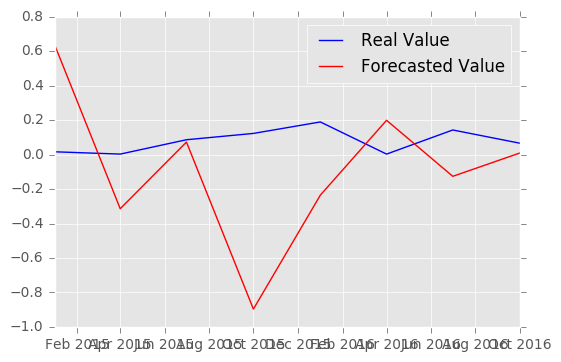

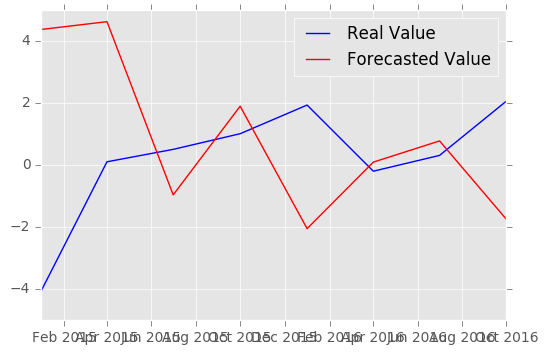

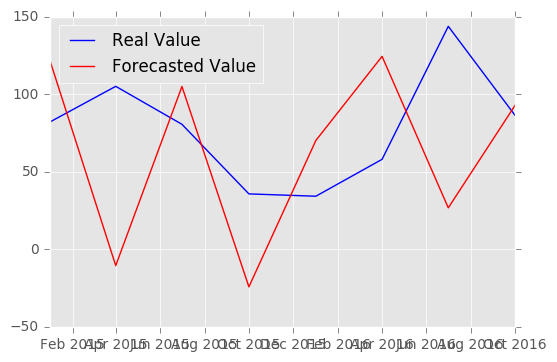

In [65]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 0.82174041280082022, 'mse': 0.81482735058306033, 'rmse': 0.90267787753055095}
{'mae': 9.5806056470723071, 'mse': 97.365052660057785, 'rmse': 9.86737313878713}
{'mae': 76.709657807790336, 'mse': 7405.3055514060979, 'rmse': 86.054085036133515}


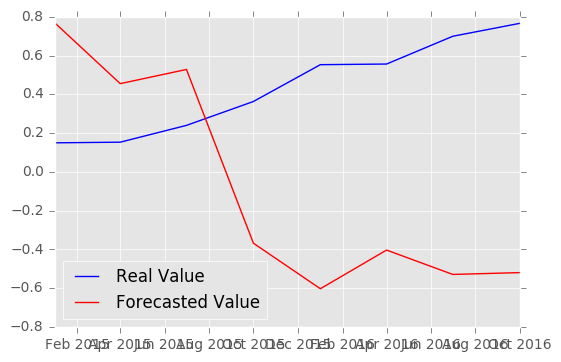

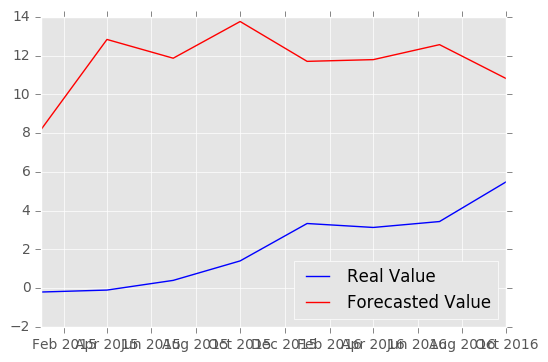

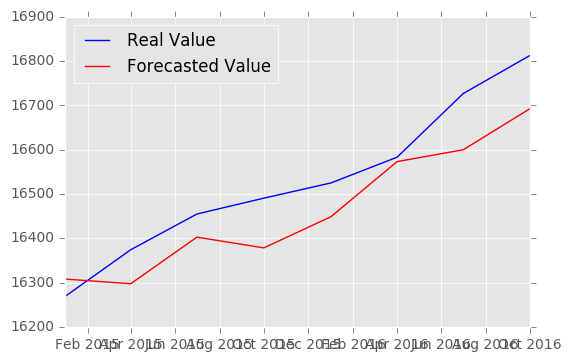

In [66]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

Второй запуск

In [67]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.0213
Epoch 2/200
0s - loss: 1.0059
Epoch 3/200
0s - loss: 1.0035
Epoch 4/200
0s - loss: 0.9995
Epoch 5/200
0s - loss: 0.9989
Epoch 6/200
0s - loss: 0.9974
Epoch 7/200
0s - loss: 0.9967
Epoch 8/200
0s - loss: 0.9937
Epoch 9/200
0s - loss: 0.9938
Epoch 10/200
0s - loss: 0.9898
Epoch 11/200
0s - loss: 0.9884
Epoch 12/200
0s - loss: 0.9884
Epoch 13/200
0s - loss: 0.9876
Epoch 14/200
0s - loss: 0.9846
Epoch 15/200
0s - loss: 0.9822
Epoch 16/200
0s - loss: 0.9793
Epoch 17/200
0s - loss: 0.9793
Epoch 18/200
0s - loss: 0.9757
Epoch 19/200
0s - loss: 0.9786
Epoch 20/200
0s - loss: 0.9752
Epoch 21/200
0s - loss: 0.9704
Epoch 22/200
0s - loss: 0.9716
Epoch 23/200
0s - loss: 0.9669
Epoch 24/200
0s - loss: 0.9669
Epoch 25/200
0s - loss: 0.9653
Epoch 26/200
0s - loss: 0.9634
Epoch 27/200
0s - loss: 0.9633
Epoch 28/200
0s - loss: 0.9619
Epoch 29/200
0s - loss: 0.9601
Epoch 30/200
0s - loss: 0.9561
Epoch 31/200
0s - loss: 0.9582
Epoch 32/200
0s - loss: 0.9533
Epoch 33/200
0s -

{'mae': 0.60240602844039026, 'mse': 0.68994520176543361, 'rmse': 0.83062940097581039}
{'mae': 2.2128843325768455, 'mse': 9.4623998437813359, 'rmse': 3.0761014033645471}
{'mae': 44.987526392956681, 'mse': 2631.4216153192656, 'rmse': 51.297384098209783}


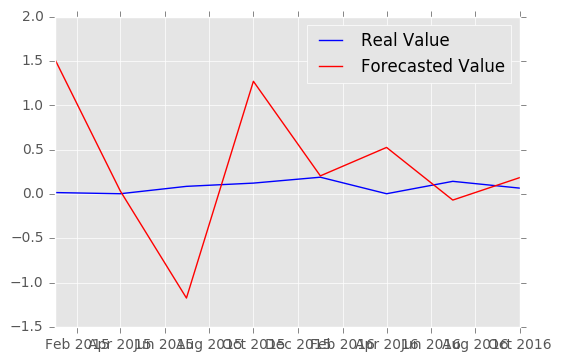

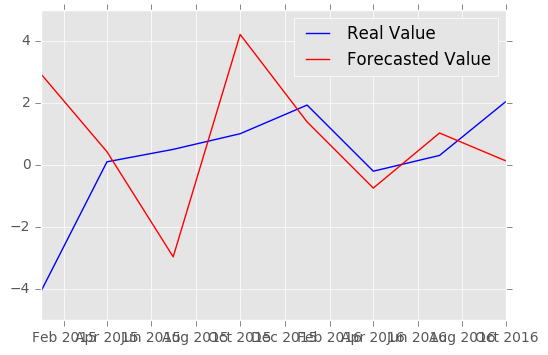

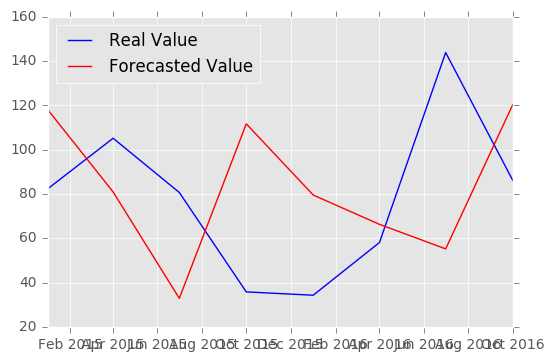

In [68]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 1.4748240210296886, 'mse': 2.4148083209583091, 'rmse': 1.5539653538474754}
{'mae': 6.1086210581027114, 'mse': 38.638862225666173, 'rmse': 6.2160165882714766}
{'mae': 43.065079648390338, 'mse': 2713.7485928827582, 'rmse': 52.093652136155306}


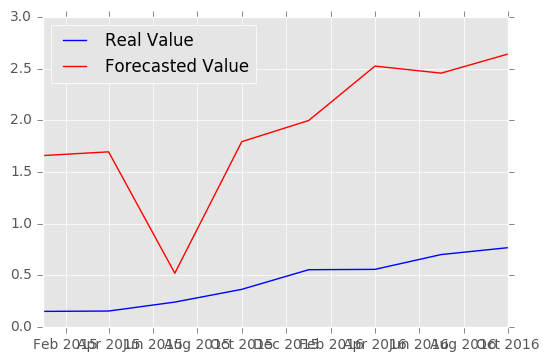

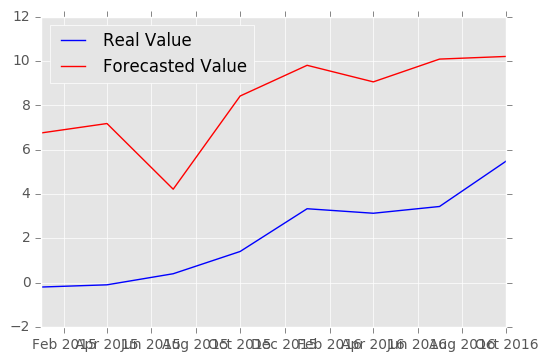

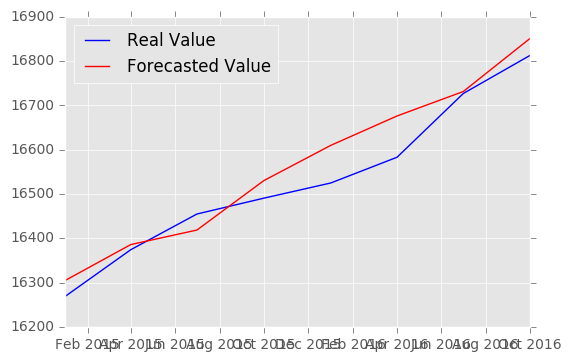

In [69]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

С DropOut

In [70]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.2719
Epoch 2/200
0s - loss: 1.0492
Epoch 3/200
0s - loss: 1.0114
Epoch 4/200
0s - loss: 1.0240
Epoch 5/200
0s - loss: 1.0089
Epoch 6/200
0s - loss: 1.0091
Epoch 7/200
0s - loss: 1.0147
Epoch 8/200
0s - loss: 1.0023
Epoch 9/200
0s - loss: 1.0024
Epoch 10/200
0s - loss: 1.0075
Epoch 11/200
0s - loss: 1.0137
Epoch 12/200
0s - loss: 0.9977
Epoch 13/200
0s - loss: 1.0042
Epoch 14/200
0s - loss: 1.0128
Epoch 15/200
0s - loss: 1.0009
Epoch 16/200
0s - loss: 0.9945
Epoch 17/200
0s - loss: 0.9936
Epoch 18/200
0s - loss: 0.9988
Epoch 19/200
0s - loss: 1.0047
Epoch 20/200
0s - loss: 1.0023
Epoch 21/200
0s - loss: 1.0066
Epoch 22/200
0s - loss: 1.0095
Epoch 23/200
0s - loss: 0.9985
Epoch 24/200
0s - loss: 0.9964
Epoch 25/200
0s - loss: 0.9948
Epoch 26/200
0s - loss: 0.9930
Epoch 27/200
0s - loss: 0.9865
Epoch 28/200
0s - loss: 0.9936
Epoch 29/200
0s - loss: 0.9965
Epoch 30/200
0s - loss: 0.9870
Epoch 31/200
0s - loss: 0.9903
Epoch 32/200
0s - loss: 0.9970
Epoch 33/200
0s -

{'mae': 0.12406347945532534, 'mse': 0.023421314242168749, 'rmse': 0.15304023733047709}
{'mae': 1.3182259085089529, 'mse': 2.8948593315202258, 'rmse': 1.7014286148764002}
{'mae': 29.3775718227675, 'mse': 1303.4764668272139, 'rmse': 36.103690487638708}


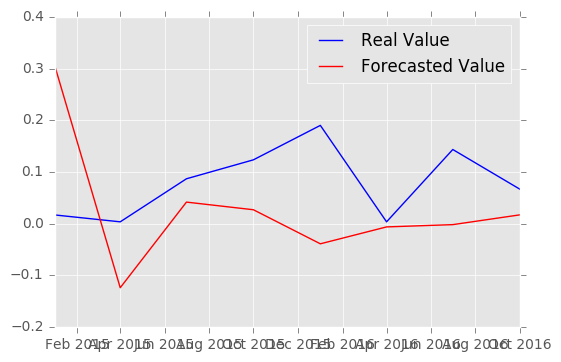

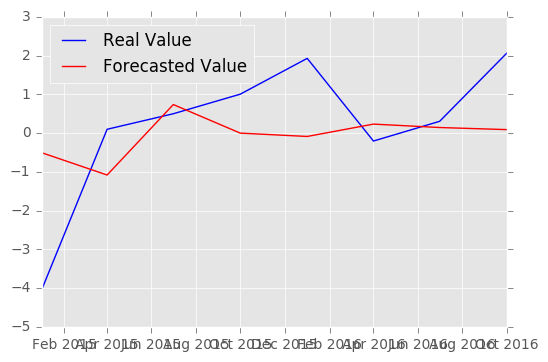

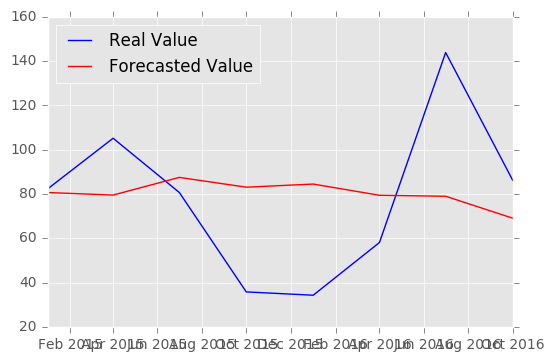

In [71]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 0.22432542113085588, 'mse': 0.065061585943498867, 'rmse': 0.25507172705632991}
{'mae': 1.5990081097260846, 'mse': 4.0106132427355954, 'rmse': 2.00265155300057}
{'mae': 37.657841263320051, 'mse': 2359.069114696405, 'rmse': 48.570249275625557}


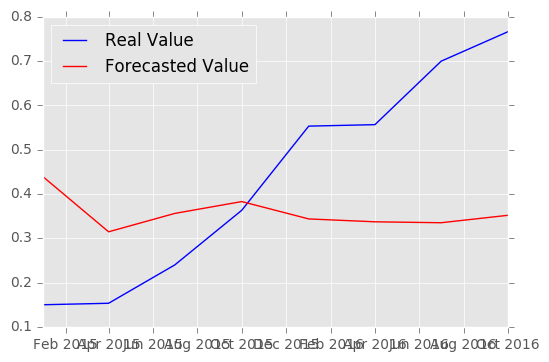

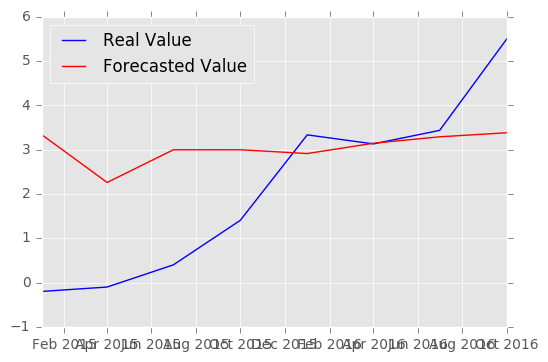

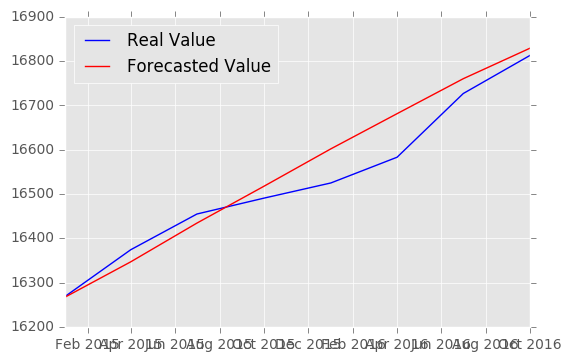

In [72]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

### Hybrid Full

In [73]:
def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [74]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.1059
Epoch 2/500
0s - loss: 0.8165
Epoch 3/500
0s - loss: 0.6706
Epoch 4/500
0s - loss: 0.5565
Epoch 5/500
0s - loss: 0.4731
Epoch 6/500
0s - loss: 0.4102
Epoch 7/500
0s - loss: 0.3629
Epoch 8/500
0s - loss: 0.3221
Epoch 9/500
0s - loss: 0.2896
Epoch 10/500
0s - loss: 0.2648
Epoch 11/500
0s - loss: 0.2469
Epoch 12/500
0s - loss: 0.2320
Epoch 13/500
0s - loss: 0.2191
Epoch 14/500
0s - loss: 0.2088
Epoch 15/500
0s - loss: 0.1973
Epoch 16/500
0s - loss: 0.1863
Epoch 17/500
0s - loss: 0.1754
Epoch 18/500
0s - loss: 0.1645
Epoch 19/500
0s - loss: 0.1566
Epoch 20/500
0s - loss: 0.1483
Epoch 21/500
0s - loss: 0.1398
Epoch 22/500
0s - loss: 0.1331
Epoch 23/500
0s - loss: 0.1267
Epoch 24/500
0s - loss: 0.1218
Epoch 25/500
0s - loss: 0.1178
Epoch 26/500
0s - loss: 0.1136
Epoch 27/500
0s - loss: 0.1109
Epoch 28/500
0s - loss: 0.1088
Epoch 29/500
0s - loss: 0.1060
Epoch 30/500
0s - loss: 0.1040
Epoch 31/500
0s - loss: 0.1024
Epoch 32/500
0s - loss: 0.1010
Epoch 33/500
0s -

{'mae': 3.2880310098830439, 'mse': 17.764769488023035, 'rmse': 4.2148273378660521}
{'mae': 5.727088720633442, 'mse': 36.1120376212439, 'rmse': 6.0093292155817108}
{'mae': 166.65711921179491, 'mse': 68597.177727403265, 'rmse': 261.9106292753375}


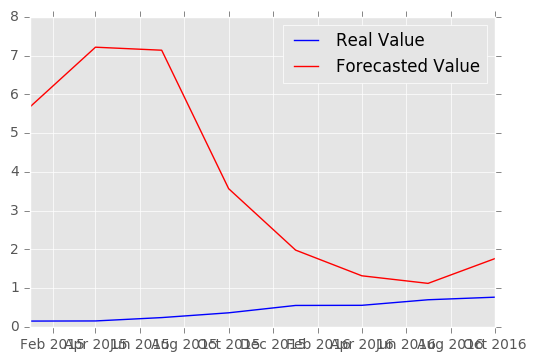

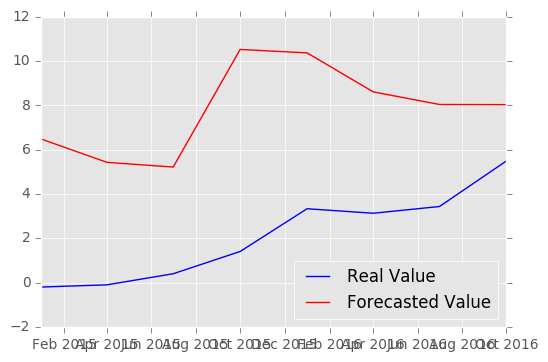

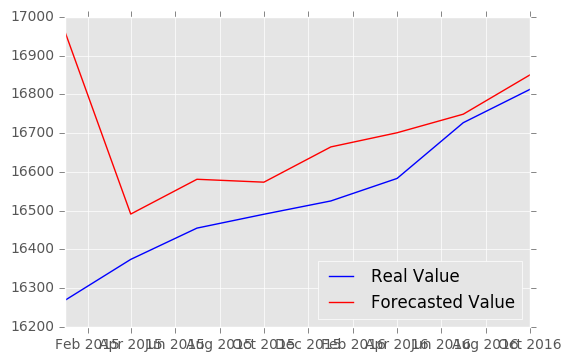

In [75]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

Второй запуск

In [76]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.1077
Epoch 2/500
0s - loss: 0.8990
Epoch 3/500
0s - loss: 0.8021
Epoch 4/500
0s - loss: 0.6972
Epoch 5/500
0s - loss: 0.5862
Epoch 6/500
0s - loss: 0.4877
Epoch 7/500
0s - loss: 0.4136
Epoch 8/500
0s - loss: 0.3620
Epoch 9/500
0s - loss: 0.3255
Epoch 10/500
0s - loss: 0.2976
Epoch 11/500
0s - loss: 0.2764
Epoch 12/500
0s - loss: 0.2599
Epoch 13/500
0s - loss: 0.2462
Epoch 14/500
0s - loss: 0.2334
Epoch 15/500
0s - loss: 0.2230
Epoch 16/500
0s - loss: 0.2132
Epoch 17/500
0s - loss: 0.2035
Epoch 18/500
0s - loss: 0.1927
Epoch 19/500
0s - loss: 0.1847
Epoch 20/500
0s - loss: 0.1754
Epoch 21/500
0s - loss: 0.1665
Epoch 22/500
0s - loss: 0.1579
Epoch 23/500
0s - loss: 0.1485
Epoch 24/500
0s - loss: 0.1412
Epoch 25/500
0s - loss: 0.1346
Epoch 26/500
0s - loss: 0.1295
Epoch 27/500
0s - loss: 0.1248
Epoch 28/500
0s - loss: 0.1192
Epoch 29/500
0s - loss: 0.1153
Epoch 30/500
0s - loss: 0.1108
Epoch 31/500
0s - loss: 0.1100
Epoch 32/500
0s - loss: 0.1071
Epoch 33/500
0s -

{'mae': 5.1916304931257162, 'mse': 28.803633789615056, 'rmse': 5.3669016936790497}
{'mae': 4.4750266262129434, 'mse': 38.079306950734868, 'rmse': 6.1708432933218189}
{'mae': 164.53434728757088, 'mse': 51625.900330491932, 'rmse': 227.21333660349239}


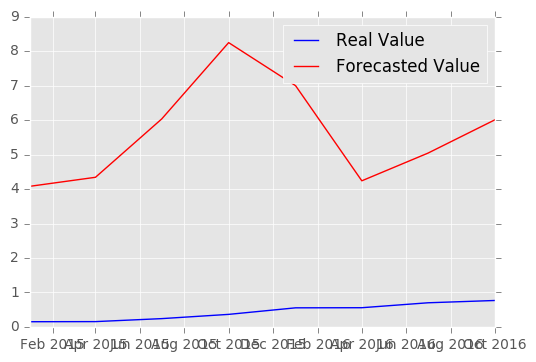

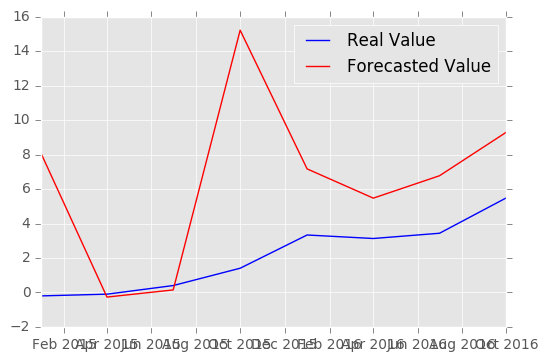

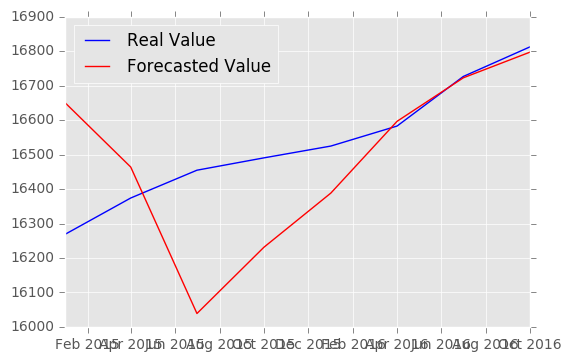

In [77]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

С DropOut

In [78]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.3239
Epoch 2/500
0s - loss: 1.0428
Epoch 3/500
0s - loss: 0.9833
Epoch 4/500
0s - loss: 0.9524
Epoch 5/500
0s - loss: 0.9416
Epoch 6/500
0s - loss: 0.9164
Epoch 7/500
0s - loss: 0.8516
Epoch 8/500
0s - loss: 0.8488
Epoch 9/500
0s - loss: 0.7656
Epoch 10/500
0s - loss: 0.7505
Epoch 11/500
0s - loss: 0.7170
Epoch 12/500
0s - loss: 0.7158
Epoch 13/500
0s - loss: 0.7140
Epoch 14/500
0s - loss: 0.6610
Epoch 15/500
0s - loss: 0.6428
Epoch 16/500
0s - loss: 0.6711
Epoch 17/500
0s - loss: 0.6379
Epoch 18/500
0s - loss: 0.6352
Epoch 19/500
0s - loss: 0.6504
Epoch 20/500
0s - loss: 0.6417
Epoch 21/500
0s - loss: 0.6232
Epoch 22/500
0s - loss: 0.6317
Epoch 23/500
0s - loss: 0.6253
Epoch 24/500
0s - loss: 0.6304
Epoch 25/500
0s - loss: 0.6277
Epoch 26/500
0s - loss: 0.6319
Epoch 27/500
0s - loss: 0.6023
Epoch 28/500
0s - loss: 0.6314
Epoch 29/500
0s - loss: 0.6131
Epoch 30/500
0s - loss: 0.5983
Epoch 31/500
0s - loss: 0.6291
Epoch 32/500
0s - loss: 0.6215
Epoch 33/500
0s -

{'mae': 6.5475511314992438, 'mse': 49.985909109834154, 'rmse': 7.0700713652575073}
{'mae': 7.2859324265928693, 'mse': 64.048171895035466, 'rmse': 8.0030101771168241}
{'mae': 111.25945549009771, 'mse': 20684.002943957501, 'rmse': 143.81934134168986}


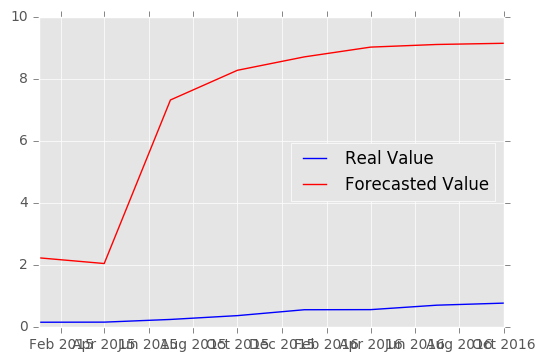

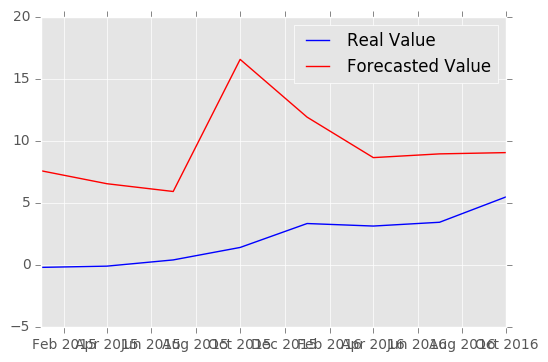

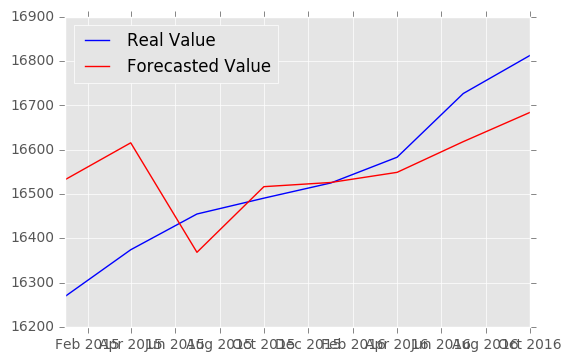

In [79]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])